In [1]:
%run models.ipynb
%run datasets.ipynb

In [2]:
import dalex as dx
import numpy as np
import shap

/home/edsuch21/anaconda3/envs/myDalex/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
svm = create_model('svm', kernel='rbf')
xgboost = create_model('xgboost')

## Szacowanie ceny mieszkań

In [4]:
X_train, X_test, y_train, y_test = get_test_train('house_price')

In [5]:
model_predicting_method = lambda m, d: m.predict(d)

In [6]:
svm.fit(X_train, y_train)
svm.score(X_test, y_test)

-0.06435106971744209

In [7]:
xgboost.fit(X_train, y_train)
xgboost.score(X_test, y_test)

0.6829726555492395

In [8]:
explainer_svm = dx.Explainer(svm, X_train, y_train, predict_function=model_predicting_method, \
                             label="SVM_house_price")
explainer_xgboost = dx.Explainer(xgboost, X_train, y_train, predict_function=model_predicting_method, \
                                 label="XGBoost_house_price")

Preparation of a new explainer is initiated

  -> data              : 14480 rows 9 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 14480 values
  -> model_class       : sklearn.svm._classes.SVR (default)
  -> label             : SVM_house_price
  -> predict function  : <function <lambda> at 0x7f87e88213b0> will be used
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.


X does not have valid feature names, but SVR was fitted with feature names


  -> predicted values  : min = 4.5e+05, mean = 4.5e+05, max = 4.5e+05
  -> model type        : regression will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -3.75e+05, mean = 8.75e+04, max = 7.25e+06
  -> model_info        : package sklearn

A new explainer has been created!
Preparation of a new explainer is initiated

  -> data              : 14480 rows 9 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 14480 values
  -> model_class       : sklearn.ensemble._gb.GradientBoostingRegressor (default)
  -> label             : XGBoost_house_price
  -> predict function  : <function <lambda> at 0x7f87e88213b0> will be used
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 1.91e+05, mean = 5.37e+05, max = 7.57e+06
  -> model type        : regression will be used (default)
  -> residual function : difference 

X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names


In [ ]:
N = 30
nb_of_features = len(X_test.columns)

nb_of_samples = [10, 30, 50, 70, 90]
contributions_xgboost = np.zeros((len(nb_of_samples), N, nb_of_features))
contributions_svm = np.zeros((len(nb_of_samples), N, nb_of_features))

for j, samples in enumerate(nb_of_samples):
    for i in range(0, N):
        print(j, i)
        for explainer, contributions in zip([explainer_xgboost, explainer_svm], \
                                            [contributions_xgboost, contributions_svm]):
            explain = explainer.predict_parts(X_test.iloc[0:1], type="unbiased_kernel_shap",
                                              n_samples = samples, label=f"sample id: 0")
            contr = explain.result['contribution'].to_numpy()
            contributions[j, i, :] = contr

0 0


X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
X does not have valid feature names, but SVR was fitted with feature names
X does not have valid feature names, but SVR was fitted with feature names


In [ ]:
avg_xgboost = np.mean(contributions_xgboost, axis = 1)
std_xgboost = np.std(contributions_xgboost, axis = 1)
avg_svm = np.mean(contributions_svm, axis = 1)
std_svm = np.std(contributions_svm, axis = 1)

In [ ]:
exact_explainer_svm = shap.explainers.Exact(svm.predict, X_train)
exact_explainer_xgboost = shap.explainers.Exact(xgboost.predict, X_train)

exact_shap_result = []
for explainer in [exact_explainer_svm, exact_explainer_xgboost]:

    shap_values = explainer(X_test.iloc[0:1])

    exact_shap_result.append(shap_values.values)

In [ ]:
svm_error = np.sum(abs(avg_svm - exact_shap_result[0])) / np.sum(exact_shap_result[0])
xgboost_error = np.sum(abs(avg_xgboost - exact_shap_result[1])) / np.sum(exact_shap_result[1])

In [ ]:
#czy można uśrednić std? czy to matematyczne brednie?

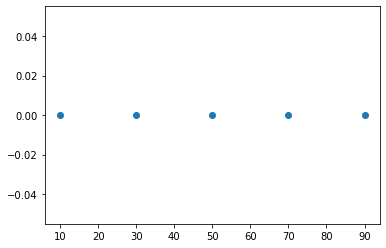

In [6]:
from matplotlib import pyplot as plt

plt.scatter(nb_of_samples, xgboost_error)